# STAT3009 Project 1
- LAW Yiu Leung Eric    1155149315
- LAM Wai Chiu          1155152095

## Import package

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

## Load the developed methods

In [2]:
from developed_methods import *

def print_T(t, test_pair, pred_rating):
	print('test_pair:', test_pair[t])
	print('pred_rating:', pred_rating[t])

## Import and pre-process the raw data
- check the `user_id` and `item_id`: mapping `item_id` to a continuous sequence based on `sklean.preprocessing`
- use `sklearn.model_selection.train_test_split` to generate `train` and `test` dataset
- create `train_pair`,`train_rating`, `test_pair`

In [3]:
dtrain = pd.read_csv("data/train.csv")
dtest = pd.read_csv("data/test.csv")

## mapping 
from sklearn import preprocessing
le_user = preprocessing.LabelEncoder()
le_user.fit(np.append(dtrain['user_id'], dtest["user_id"]))
dtrain['user_id'] = le_user.transform(dtrain["user_id"])
dtest["user_id"] = le_user.transform(dtest["user_id"])

le_item = preprocessing.LabelEncoder()
le_item.fit(np.append(dtrain['item_id'], dtest["item_id"]))
dtrain["item_id"] = le_item.transform(dtrain["item_id"])
dtest["item_id"] = le_item.transform(dtest["item_id"])

Create train_pair, train_rating and test_pair

In [4]:
# train_pair, train_rating
train_pair = dtrain[['user_id', 'item_id']].values
train_rating = dtrain['rating'].values

# test_pair
test_pair = dtest[['user_id', 'item_id']].values
n_user, n_item = max(train_pair[:,0].max(), test_pair[:,0].max())+1, max(train_pair[:,1].max(), test_pair[:,1].max())+1

## Exploratory data analysis (EDA)
- User rating of the items

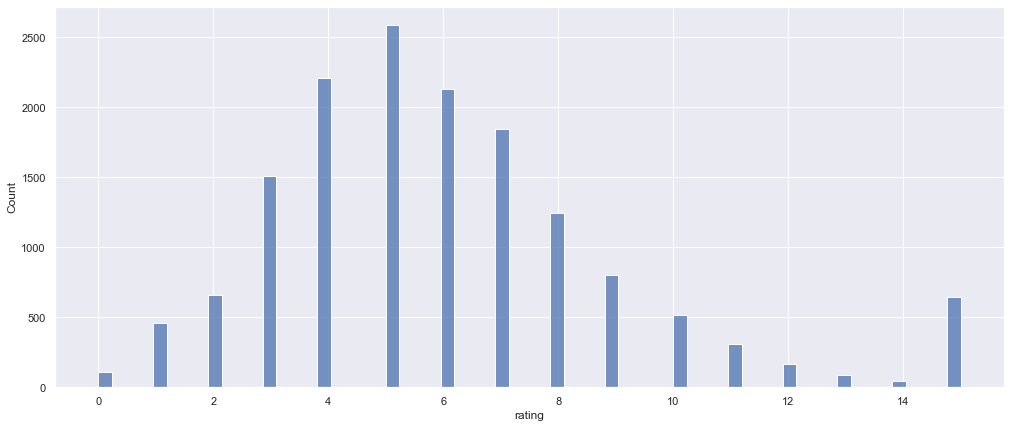

In [5]:
sns.set_theme()
## histograms of rating 
plt.figure(1, figsize=(17, 7))
sns.histplot(data=dtrain, x="rating")
plt.show()

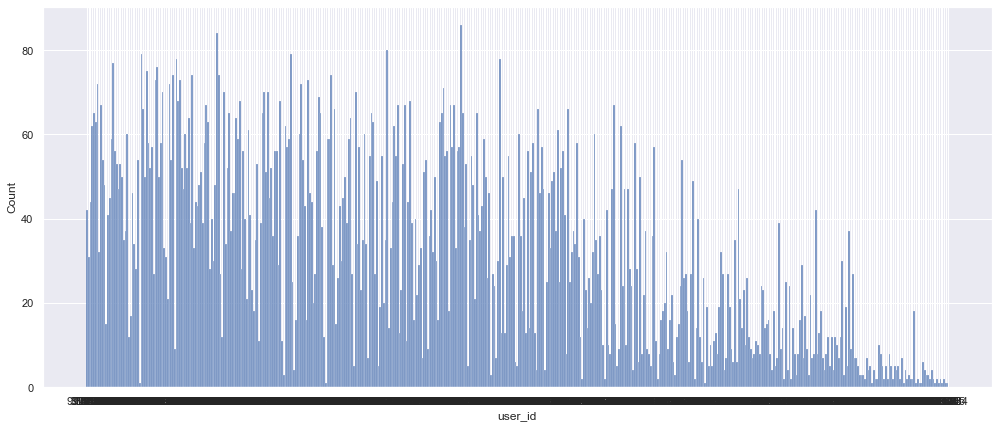

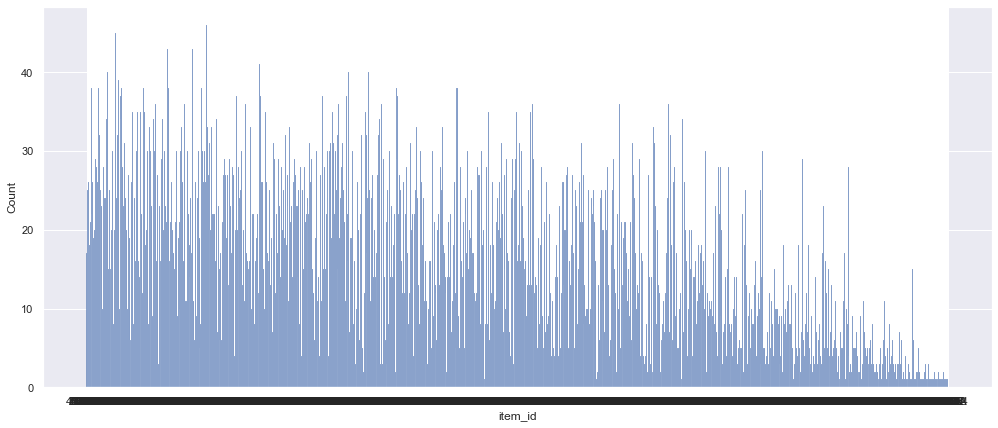

In [74]:
## histograms of user 
plt.figure(1, figsize=(17, 7))
sns.histplot(data=dtrain, x="user_id")
plt.show()
## histograms of item 
plt.figure(1, figsize=(17, 7))
sns.histplot(data=dtrain, x="item_id")
plt.show()

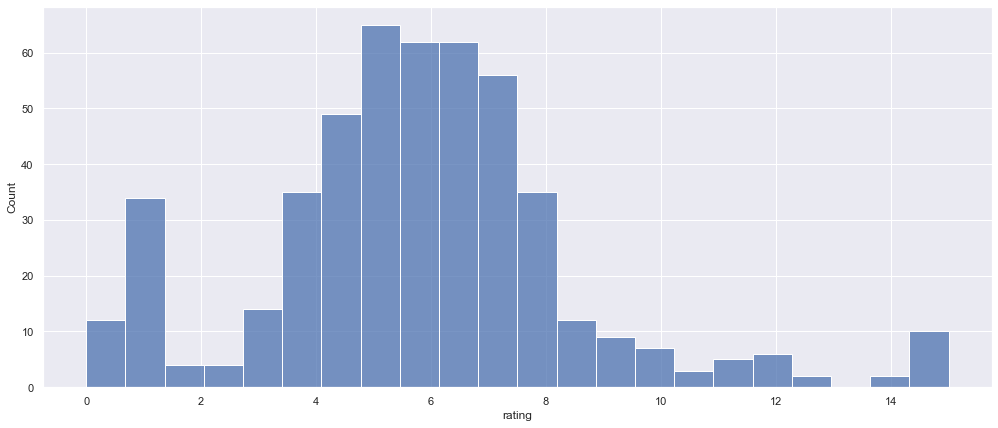

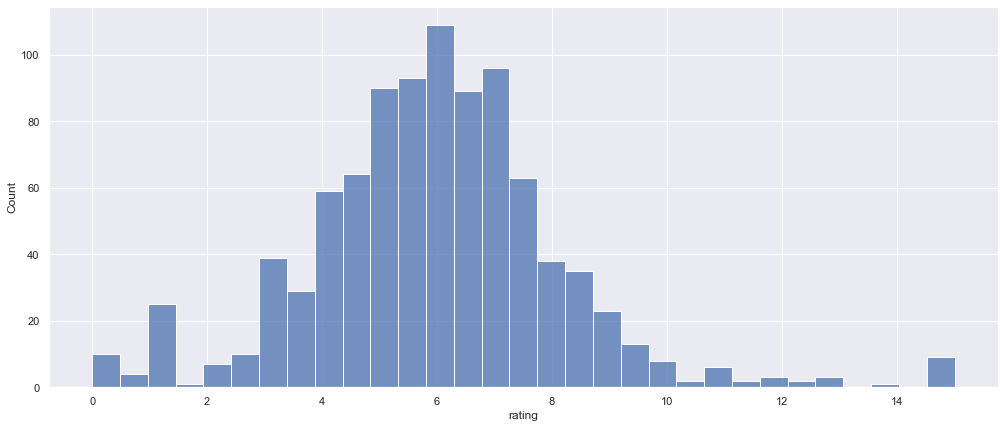

In [8]:
# histgrams for averaged ratings for users/items
plt.figure(1, figsize=(17, 7))
sns.histplot(dtrain.groupby('user_id')['rating'].mean())
plt.show()
plt.figure(1, figsize=(17, 7))
sns.histplot(dtrain.groupby('item_id')['rating'].mean())
plt.show()

In [9]:
## Find Top-20 highest rating items
pd.DataFrame(dtrain.groupby('item_id')['rating'].mean().sort_values(ascending = False)[:20], columns =['rating'])

,rating
item_id,
580,15.0
650,15.0
102,15.0
117,15.0
65,15.0
64,15.0
252,15.0
936,15.0
403,15.0


         Count
item_id       
953         37
95          31
568         30
757         30
451         29
253         29
678         29
281         28
914         28
265         28
680         28
479         28
131         28
552         27
234         27
876         27
306         27
942         27
558         27
122         27


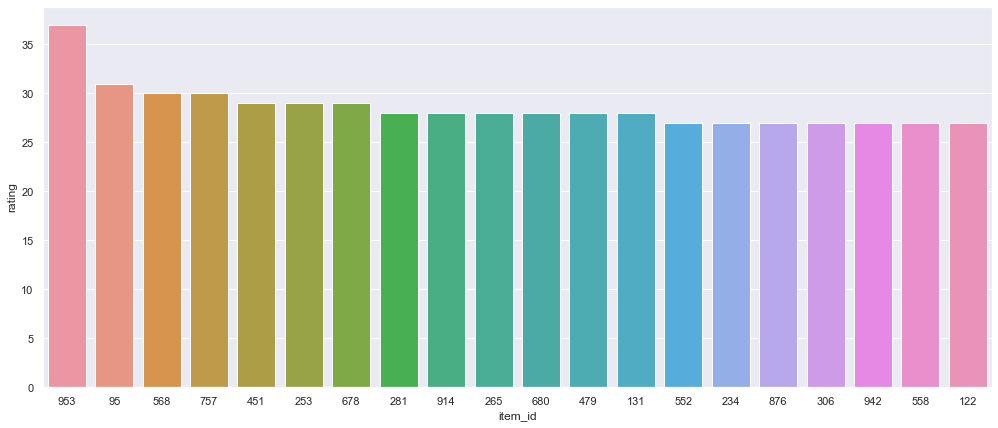

In [10]:
## Find Top-20 most popular items 
dtmp = dtrain.groupby('item_id')['rating'].count().sort_values(ascending = False)[:20]
df=pd.DataFrame(dtrain.groupby('item_id')['rating'].count().sort_values(ascending = False)[:20])
df.columns =['Count']
print(df)
plt.figure(1, figsize=(17, 7))
sns.barplot(x=df.index, y=dtmp, order=dtmp.index)
plt.show()

## Use the developed methods to predict ratings

GLB_LFM

In [9]:
## GLB_mean
glb_ave = glb_mean()
glb_ave.fit(train_rating)
pred_glb = glb_ave.predict(test_pair)
train_rating_cm = train_rating - glb_ave.predict(train_pair)

## fit GLB_mean + LFM_CV by residual ratings 
Ks, lams = [3,5,10,15,20],[0.0001,0.0005,0.001,0.01]
shiing_cv = LFM_CV(n_user, n_item, cv=5, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pair, train_rating_cm)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing=LFM(n_user, n_item, K=best_K, lam=best_lam)
shiing.fit(train_pair, train_rating_cm)
pred = pred_glb + shiing.predict(test_pair)
pred_rating = pred

KeyboardInterrupt: 

In [111]:
## print T-th record and top-5 preferred items
print_T(2095,temp_test_pair,pred_rating)
print_top5(2095,temp_test_pair,pred_rating)

# submission
sub['rating'] = pred_rating
sub.to_csv('GLB_LFM.csv', index=False)

test_pair: ['D7F746' 'E36CD5']
pred_rating: 4.830147075173101
  item   rating
4BC7F1 5.710617
E36CD5 5.423305
604A4B 4.830147
A98D40 3.853656
F89A64 3.442442


GLB_user_mean_LMF

In [8]:
# user_mean
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_ratings=train_rating_cm)
pred_user_mean = pred_glb + user_ave.predict(test_pair)

# fit GLB + user_mean + LFM_CV by residual ratings 
train_rating_res = train_rating_cm - user_ave.predict(train_pair)
Ks, lams = [3,5,10,15,20],[0.0001,0.0005,0.001,0.01]
shiing_cv = LFM_CV(n_user, n_item, cv=5, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pair, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing=LFM(n_user, n_item, K=best_K, lam=best_lam)
shiing.fit(train_pair, train_rating_res)
pred = pred + shiing.predict(test_pair)
pred_rating = pred

NameError: name 'train_rating_cm' is not defined

In [101]:
## print T-th record and top-5 preferred items
print_T(2095,temp_test_pair,pred_rating)
print_top5(2095,temp_test_pair,pred_rating)

# submission
sub['rating'] = pred_rating
sub.to_csv('GLB_user_mean_LFM.csv', index=False)

test_pair: ['D7F746' 'E36CD5']
pred_rating: 5.233236337113196
  item   rating
4BC7F1 6.623828
E36CD5 6.325177
604A4B 5.233236
F89A64 2.672779
A98D40 2.168624


GLB_item_mean_LMF

5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.929, valid_rmse: 1.660
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.908, valid_rmse: 1.619
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.917, valid_rmse: 1.692
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.996, valid_rmse: 2.272
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.928, valid_rmse: 1.707
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.113, valid_rmse: 1.557
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.107, valid_rmse: 1.587
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.102, valid_rmse: 1.591
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.109, valid_rmse: 1.606
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.094, valid_rmse: 1.499
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.349, valid_rmse: 1.649
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.343, valid_rmse: 1.647
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.340, valid_rmse: 1.670
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.337, valid_rmse: 1.661
5-Fold

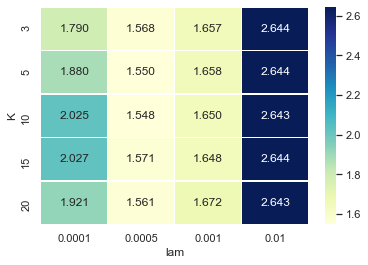

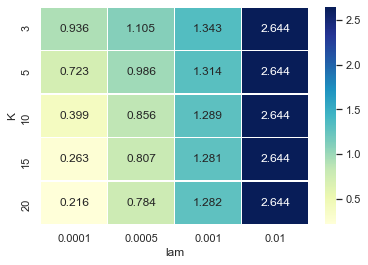

Fitting Reg-LFM: K: 10, lam: 0.00050
Reg-LFM: ite: 0; diff: 0.612 RMSE: 1.574
Reg-LFM: ite: 1; diff: 0.315 RMSE: 1.078
Reg-LFM: ite: 2; diff: 0.057 RMSE: 1.017
Reg-LFM: ite: 3; diff: 0.034 RMSE: 0.982
Reg-LFM: ite: 4; diff: 0.024 RMSE: 0.959
Reg-LFM: ite: 5; diff: 0.017 RMSE: 0.943
Reg-LFM: ite: 6; diff: 0.013 RMSE: 0.931
Reg-LFM: ite: 7; diff: 0.010 RMSE: 0.922
Reg-LFM: ite: 8; diff: 0.008 RMSE: 0.915
Reg-LFM: ite: 9; diff: 0.006 RMSE: 0.909


In [102]:
## item mean
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pair, train_ratings=train_rating_cm)
pred_item_mean = pred_glb + item_ave.predict(test_pair)

# fit GLB + item_mean + LFM_CV by residual ratings 
train_rating_res = train_rating_cm - item_ave.predict(train_pair)
Ks, lams = [3,5,10,15,20],[0.0001,0.0005,0.001,0.01]
shiing_cv = LFM_CV(n_user, n_item, cv=5, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pair, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing=LFM(n_user, n_item, K=best_K, lam=best_lam)
shiing.fit(train_pair, train_rating_res)
pred = pred + shiing.predict(test_pair)
pred_rating = pred

In [103]:
## print T-th record and top-5 preferred items
print_T(2095,temp_test_pair,pred_rating)
print_top5(2095,temp_test_pair,pred_rating)

# submission
sub['rating'] = pred_rating
sub.to_csv('GLB_item_mean_LFM.csv', index=False)

test_pair: ['D7F746' 'E36CD5']
pred_rating: 4.070218075329894
  item   rating
90EC84 5.325922
E36CD5 4.717599
604A4B 4.070218
A98D40 1.810112
F89A64 1.551450


user_item_mean_LMF

5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.791, valid_rmse: 1.375
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.805, valid_rmse: 1.356
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.806, valid_rmse: 1.288
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.796, valid_rmse: 1.300
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.800, valid_rmse: 1.287
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.924, valid_rmse: 1.116
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.919, valid_rmse: 1.128
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.919, valid_rmse: 1.141
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.922, valid_rmse: 1.080
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.934, valid_rmse: 1.137
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.100, valid_rmse: 1.135
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.095, valid_rmse: 1.131
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.104, valid_rmse: 1.162
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.100, valid_rmse: 1.142
5-Fold

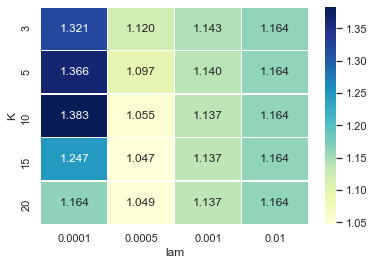

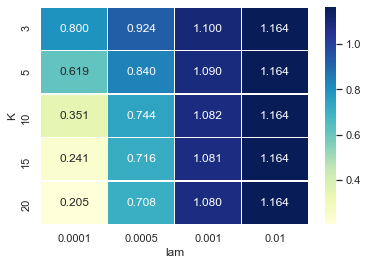

Fitting Reg-LFM: K: 15, lam: 0.00050
Reg-LFM: ite: 0; diff: 0.757 RMSE: 0.999
Reg-LFM: ite: 1; diff: 0.099 RMSE: 0.900
Reg-LFM: ite: 2; diff: 0.073 RMSE: 0.835
Reg-LFM: ite: 3; diff: 0.038 RMSE: 0.803
Reg-LFM: ite: 4; diff: 0.021 RMSE: 0.786
Reg-LFM: ite: 5; diff: 0.013 RMSE: 0.776
Reg-LFM: ite: 6; diff: 0.008 RMSE: 0.770
Reg-LFM: ite: 7; diff: 0.005 RMSE: 0.766
Reg-LFM: ite: 8; diff: 0.004 RMSE: 0.763
Reg-LFM: ite: 9; diff: 0.002 RMSE: 0.761


In [29]:
## user_mean + item mean + LFM
## user_mean 
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_ratings=train_rating)
pred = user_ave.predict(test_pair)

## item_mean
train_rating_cm = train_rating - user_ave.predict(train_pair)
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pair, train_ratings=train_rating_cm)
train_rating_res = train_rating_cm - item_ave.predict(train_pair)
pred = pred + item_ave.predict(test_pair)

## fit user_mean + item_mean + LFM_CV by residual ratings 
Ks, lams = [3,5,10,15,20],[0.0001,0.0005,0.001,0.01]
shiing_cv = LFM_CV(n_user, n_item, cv=5, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pair, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing=LFM(n_user, n_item, K=best_K, lam=best_lam)
shiing.fit(train_pair, train_rating_res)
pred = pred + shiing.predict(test_pair)
pred_rating = pred

In [30]:
## print T-th record and top-5 preferred items
print_T(2095,temp_test_pair,pred_rating)
print_top5(2095,temp_test_pair,pred_rating)

# submission
sub['rating'] = pred_rating
sub.to_csv('user_item_mean_LFM.csv', index=False)

## RMSE=1.149

test_pair: ['D7F746' 'E36CD5']
pred_rating: 4.322248330704945
  item   rating
604A4B 6.596046
A98D40 5.703949
F89A64 5.622304
E36CD5 4.322248
4BC7F1 3.156576


item_user_mean_LMF

5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.870, valid_rmse: 1.502
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.862, valid_rmse: 1.394
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.856, valid_rmse: 1.493
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.873, valid_rmse: 1.438
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.862, valid_rmse: 1.402
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.997, valid_rmse: 1.234
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.989, valid_rmse: 1.269
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.995, valid_rmse: 1.208
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.001, valid_rmse: 1.217
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.005, valid_rmse: 1.232
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.186, valid_rmse: 1.243
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.186, valid_rmse: 1.237
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.185, valid_rmse: 1.275
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.185, valid_rmse: 1.250
5-Fold

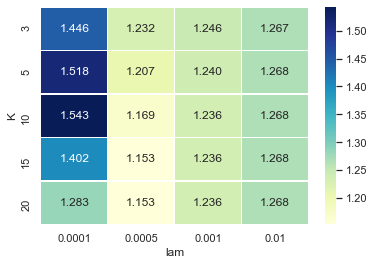

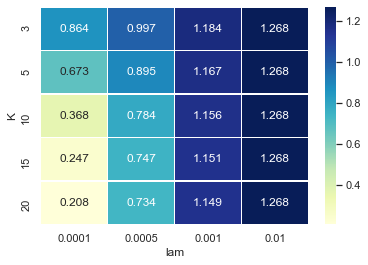

Fitting Reg-LFM: K: 15, lam: 0.00050
Reg-LFM: ite: 0; diff: 0.739 RMSE: 1.063
Reg-LFM: ite: 1; diff: 0.105 RMSE: 0.951
Reg-LFM: ite: 2; diff: 0.071 RMSE: 0.884
Reg-LFM: ite: 3; diff: 0.040 RMSE: 0.849
Reg-LFM: ite: 4; diff: 0.023 RMSE: 0.829
Reg-LFM: ite: 5; diff: 0.015 RMSE: 0.817
Reg-LFM: ite: 6; diff: 0.010 RMSE: 0.809
Reg-LFM: ite: 7; diff: 0.007 RMSE: 0.803
Reg-LFM: ite: 8; diff: 0.005 RMSE: 0.798
Reg-LFM: ite: 9; diff: 0.004 RMSE: 0.796


In [8]:
## item mean + user_mean + LFM
## item_mean 
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pair, train_ratings=train_rating)
pred = item_ave.predict(test_pair)

## user_mean
train_rating_cm = train_rating - item_ave.predict(train_pair)
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_ratings=train_rating_cm)
train_rating_res = train_rating_cm - user_ave.predict(train_pair)
pred = pred + user_ave.predict(test_pair)

## fit user_mean + item_mean + LFM_CV by residual ratings 
Ks, lams = [3,5,10,15,20],[0.0001,0.0005,0.001,0.01]
shiing_cv = LFM_CV(n_user, n_item, cv=5, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pair, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing=LFM(n_user, n_item, K=best_K, lam=best_lam)
shiing.fit(train_pair, train_rating_res)
pred = pred + shiing.predict(test_pair)
pred_rating = pred

In [9]:
## print T-th record and top-5 preferred items
print_T(2095,temp_test_pair,pred_rating)
print_top5(2095,temp_test_pair,pred_rating)

# submission
sub['rating'] = pred_rating
sub.to_csv('item_user_mean_LFM.csv', index=False)

test_pair: ['D7F746' 'E36CD5']
pred_rating: 3.699872847611943
  item   rating
4BC7F1 6.904534
E36CD5 5.675935
604A4B 3.699873
A98D40 3.223570
F89A64 2.013034


GLB_item_user_mean_LMF

5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.864, valid_rmse: 1.443
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.866, valid_rmse: 1.423
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.862, valid_rmse: 1.488
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.860, valid_rmse: 1.453
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.864, valid_rmse: 1.417
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.994, valid_rmse: 1.234
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.988, valid_rmse: 1.224
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.997, valid_rmse: 1.260
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.012, valid_rmse: 1.258
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.002, valid_rmse: 1.231
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.179, valid_rmse: 1.255
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.176, valid_rmse: 1.234
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.185, valid_rmse: 1.239
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.176, valid_rmse: 1.256
5-Fold

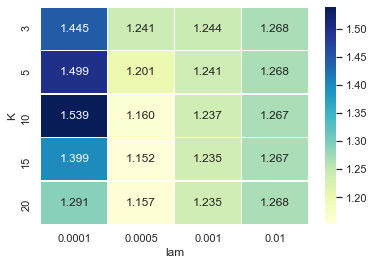

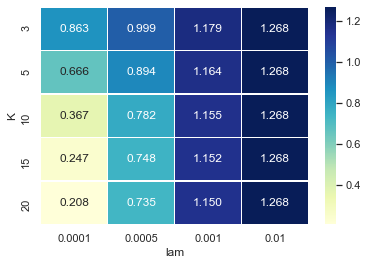

Fitting Reg-LFM: K: 15, lam: 0.00050
Reg-LFM: ite: 0; diff: 0.742 RMSE: 1.056
Reg-LFM: ite: 1; diff: 0.104 RMSE: 0.946
Reg-LFM: ite: 2; diff: 0.071 RMSE: 0.879
Reg-LFM: ite: 3; diff: 0.039 RMSE: 0.844
Reg-LFM: ite: 4; diff: 0.023 RMSE: 0.825
Reg-LFM: ite: 5; diff: 0.015 RMSE: 0.812
Reg-LFM: ite: 6; diff: 0.010 RMSE: 0.804
Reg-LFM: ite: 7; diff: 0.006 RMSE: 0.799
Reg-LFM: ite: 8; diff: 0.004 RMSE: 0.796
Reg-LFM: ite: 9; diff: 0.003 RMSE: 0.793


In [108]:
# glb mean
glb_ave = glb_mean()
glb_ave.fit(train_rating)
pred = glb_ave.predict(test_pair)

# item_mean
train_rating_res = train_rating - glb_ave.predict(train_pair)
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pair, train_ratings=train_rating_res)
pred = pred + item_ave.predict(test_pair)

# user_mean
train_rating_res -= item_ave.predict(train_pair)
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_ratings=train_rating_res)
train_rating_res -= user_ave.predict(train_pair)
pred = pred + user_ave.predict(test_pair)

# fit GLB + user_mean + item_mean + LFM_CV by residual ratings 
Ks, lams = [3,5,10,15,20],[0.0001,0.0005,0.001,0.01]
shiing_cv = LFM_CV(n_user, n_item, cv=5, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pair, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing=LFM(n_user, n_item, K=best_K, lam=best_lam)
shiing.fit(train_pair, train_rating_res)
pred = pred + shiing.predict(test_pair)
pred_rating = pred

In [109]:
## print T-th record and top-5 preferred items
print_T(2095,temp_test_pair,pred_rating)
print_top5(2095,temp_test_pair,pred_rating)

# submission
sub['rating'] = pred_rating
sub.to_csv('GLB_item_user_mean_LFM.csv', index=False)

test_pair: ['D7F746' 'E36CD5']
pred_rating: 3.721348496876555
  item   rating
4BC7F1 6.914685
E36CD5 5.597167
604A4B 3.721348
A98D40 3.112566
F89A64 1.986474


GLB_user_item_mean_LMF

In [6]:
# glb mean
glb_ave = glb_mean()
glb_ave.fit(train_rating)
pred = glb_ave.predict(test_pair)

# user_mean
train_rating_res = train_rating - glb_ave.predict(train_pair)
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_ratings=train_rating_res)
pred = pred + user_ave.predict(test_pair)

# item_mean
train_rating_res -=  user_ave.predict(train_pair)
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pair, train_ratings=train_rating_res)
pred = pred + item_ave.predict(test_pair)


# fit GLB + user_mean + item_mean + LFM_CV by residual ratings 
Ks, lams = [3,5,10,15,20],[0.0001,0.0005,0.001,0.01]
shiing_cv = LFM_CV(n_user, n_item, cv=5, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pair, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing=LFM(n_user, n_item, K=best_K, lam=best_lam)
shiing.fit(train_pair, train_rating_res)
pred = pred + shiing.predict(test_pair)
pred_rating = pred

5-Fold CV for K: 3; lam: 0.00010: train_rmse: 1.664, valid_rmse: 2.093


KeyboardInterrupt: 

In [32]:
## print T-th record and top-5 preferred items
print_T(2095,temp_test_pair,pred_rating)
print_top5(2095,temp_test_pair,pred_rating)

# submission
sub['rating'] = pred_rating
sub.to_csv('GLB_user_item_mean_LFM.csv', index=False)

test_pair: ['D7F746' 'E36CD5']
pred_rating: 4.782893392498797
  item   rating
604A4B 8.152251
A98D40 6.855999
F89A64 6.714650
E36CD5 4.782893
4BC7F1 2.519099


In [ ]:
### Note2: the computation complexity is not relative large for `augmentation step`, yet it might be solved by `SGD`.

In [19]:
## Baseline + LFM
# glb mean
glb_ave = glb_mean()
glb_ave.fit(train_rating)
pred = glb_ave.predict(test_pair)

# user_mean
train_rating_cm = train_rating - glb_ave.predict(train_pair)
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_ratings=train_rating_cm)
train_rating_res = train_rating_cm - user_ave.predict(train_pair)
pred = pred + user_ave.predict(test_pair)

## item_mean
train_rating_cm = train_rating_cm - user_ave.predict(train_pair)
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pair, train_ratings=train_rating_cm)
train_rating_res = train_rating_cm - item_ave.predict(train_pair)
pred = pred + item_ave.predict(test_pair)

## refit the best model, and make prediction
shiing=LFM(n_user, n_item, K=best_K, lam=best_lam)
shiing.fit(train_pair=train_pair, train_rating=train_rating_res, learning_rate=.001)
pred = pred + shiing.predict(test_pair)

Fitting Reg-LFM: K: 3, lam: 0.00050
Reg-LFM: ite: 0; diff: 0.056 RMSE: 2.006
Reg-LFM: ite: 1; diff: 0.052 RMSE: 1.954
Reg-LFM: ite: 2; diff: 0.049 RMSE: 1.905
Reg-LFM: ite: 3; diff: 0.046 RMSE: 1.860
Reg-LFM: ite: 4; diff: 0.042 RMSE: 1.817
Reg-LFM: ite: 5; diff: 0.040 RMSE: 1.777
Reg-LFM: ite: 6; diff: 0.037 RMSE: 1.740
Reg-LFM: ite: 7; diff: 0.035 RMSE: 1.706
Reg-LFM: ite: 8; diff: 0.033 RMSE: 1.673
Reg-LFM: ite: 9; diff: 0.030 RMSE: 1.643
Reg-LFM: ite: 10; diff: 0.029 RMSE: 1.614
Reg-LFM: ite: 11; diff: 0.027 RMSE: 1.587
Reg-LFM: ite: 12; diff: 0.025 RMSE: 1.562
Reg-LFM: ite: 13; diff: 0.024 RMSE: 1.538
Reg-LFM: ite: 14; diff: 0.022 RMSE: 1.516
Reg-LFM: ite: 15; diff: 0.021 RMSE: 1.495
Reg-LFM: ite: 16; diff: 0.020 RMSE: 1.475
Reg-LFM: ite: 17; diff: 0.019 RMSE: 1.456
Reg-LFM: ite: 18; diff: 0.018 RMSE: 1.438
Reg-LFM: ite: 19; diff: 0.017 RMSE: 1.422
Reg-LFM: ite: 20; diff: 0.016 RMSE: 1.406
Reg-LFM: ite: 21; diff: 0.015 RMSE: 1.391
Reg-LFM: ite: 22; diff: 0.014 RMSE: 1.377
Reg-LFM:

In [23]:
test_pair_submit = dtest[["user_id", "item_id"]].values

## Baseline + LFM
# glb mean
pred = glb_ave.predict(test_pair_submit)

# user_mean
pred = pred + user_ave.predict(test_pair_submit)

## item_mean
pred = pred + item_ave.predict(test_pair_submit)

## refit the best model, and make prediction
pred = pred + shiing.predict(test_pair_submit)

In [37]:
# Adjust the prediction within [0, 15]
def adjust(pred_rating, score_min, score_max):
    pred_rating = pred_rating.copy()
    pred_rating = [max(score_min, pred_rating[i]) for i in range(len(pred_rating))]
    pred_rating = [min(score_max, pred_rating[i]) for i in range(len(pred_rating))]
    return pred_rating

In [38]:
# Make your prediction
# pred_rating is an array of your prediction for `dtest`
pred_rating = adjust(pred, 0, 15)

# submission
sub = pd.DataFrame({"id": range(len(dtest)), "rating": pred_rating})
sub.to_csv('predict/GLB_user_item_mean_LFMSGD.csv', index=False)

## Then submit the csv to the competition in Kaggle

In [40]:
min(pred_rating)

0

In [199]:
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_ratings=train_rating)
pred = user_ave.predict(test_pair)

## item_mean
train_rating_cm = train_rating - user_ave.predict(train_pair)
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pair, train_ratings=train_rating_cm)
train_rating_res = train_rating_cm - item_ave.predict(train_pair)
pred = pred + item_ave.predict(test_pair)
## refit the best model, and make prediction

shiing=LFM(n_user, n_item, K=3, lam=best_lam)
shiing.fit(train_pair=train_pair, train_rating=train_rating_res, learning_rate=.001)
pred = pred + shiing.predict(test_pair)


Fitting Reg-LFM: K: 3, lam: 0.00050
Reg-LFM: ite: 0; diff: 0.086 RMSE: 2.075
Reg-LFM: ite: 1; diff: 0.078 RMSE: 1.997
Reg-LFM: ite: 2; diff: 0.071 RMSE: 1.926
Reg-LFM: ite: 3; diff: 0.065 RMSE: 1.861
Reg-LFM: ite: 4; diff: 0.059 RMSE: 1.802
Reg-LFM: ite: 5; diff: 0.054 RMSE: 1.749
Reg-LFM: ite: 6; diff: 0.049 RMSE: 1.700
Reg-LFM: ite: 7; diff: 0.045 RMSE: 1.655
Reg-LFM: ite: 8; diff: 0.041 RMSE: 1.614
Reg-LFM: ite: 9; diff: 0.037 RMSE: 1.577
Reg-LFM: ite: 10; diff: 0.034 RMSE: 1.543
Reg-LFM: ite: 11; diff: 0.031 RMSE: 1.512
Reg-LFM: ite: 12; diff: 0.029 RMSE: 1.483
Reg-LFM: ite: 13; diff: 0.026 RMSE: 1.456
Reg-LFM: ite: 14; diff: 0.024 RMSE: 1.432
Reg-LFM: ite: 15; diff: 0.022 RMSE: 1.410
Reg-LFM: ite: 16; diff: 0.021 RMSE: 1.389
Reg-LFM: ite: 17; diff: 0.019 RMSE: 1.370
Reg-LFM: ite: 18; diff: 0.018 RMSE: 1.352
Reg-LFM: ite: 19; diff: 0.016 RMSE: 1.336
Reg-LFM: ite: 20; diff: 0.015 RMSE: 1.321
Reg-LFM: ite: 21; diff: 0.014 RMSE: 1.307
Reg-LFM: ite: 22; diff: 0.013 RMSE: 1.294
Reg-LFM:

In [200]:
# Make your prediction
# pred_rating is an array of your prediction for `dtest`


# submission
sub['rating'] = pred_rating
sub.to_csv('user_item_mean_LFMSGD.csv', index=False)

## Then just submit sub1.csv to the competition in Kaggle

In [13]:
pred

array([12.73030964, 17.99001373, 17.29738727, ..., 15.02221017,
       23.32010652, 19.27083655])

In [24]:
t=2095
print_T(2095,temp_test_pair,pred_rating)
user_index=np.where(temp_test_pair[:,0]==temp_test_pair[t,0])[0]
item_index=pred_rating[user_index].argsort()[-5:][::-1]
list1=temp_test_pair[user_index,1][item_index]
list2=pred_rating[user_index][item_index]
result = pd.DataFrame(list(zip(list1, list2)), columns =['item', 'rating'])
print(result.sort_values(by='rating', ascending=False).to_string(index=False))


test_pair: ['D7F746' 'E36CD5']
pred_rating: 3.699872847611943
  item   rating
604A4B 6.904534
A98D40 5.806089
F89A64 5.675935
E36CD5 3.699873
4BC7F1 3.223570


In [22]:
user_index

array([2095, 2178, 2506, 2637, 3580, 3772], dtype=int64)

In [21]:
user_index[item_index]

array([3580, 3772, 2637, 2095, 2178], dtype=int64)

In [19]:
pred_rating[user_index].argsort()[-5:][::-1]

array([4, 5, 3, 0, 1], dtype=int64)

In [17]:
pred_rating[item_index]

array([4.38864445, 3.8147658 , 4.47341606, 2.59799852, 5.33317706])